<a href="https://colab.research.google.com/github/ahmedsakrs/Data-Classification/blob/main/Gamma_telescope_Lab3_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artificial intelligence
#Lab 3 

## Setup

In [ ]:
!gdown 13BS7rDYb8Cwd197iSRtaHZ4gFpQjhB8O

Downloading...
From: https://drive.google.com/uc?id=13BS7rDYb8Cwd197iSRtaHZ4gFpQjhB8O
To: /content/magic04.dat.csv
100% 1.48M/1.48M [00:00<00:00, 162MB/s]


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
data = pd.read_csv('/content/magic04.dat.csv', names=('fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class'))

In [ ]:
data.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


## Data balancing

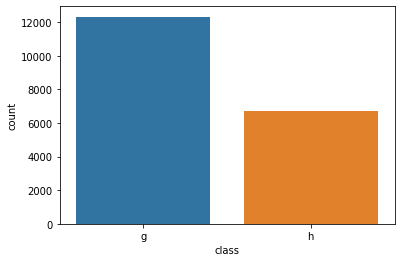

In [ ]:
sns.countplot(x='class', data=data)

The dataset is unbalanced as shown in the graph.

Here we would do under sampling to balance the data.

In [ ]:
g, h = data['class'].value_counts()

In [ ]:
g_df = data[data['class'] == 'g']
h_df = data[data['class'] == 'h']

g_df = g_df.sample(h)

data = pd.concat([h_df, g_df], axis=0)
data.reset_index(drop=True, inplace=True)

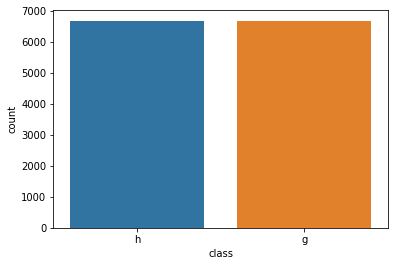

In [ ]:
sns.countplot(x='class', data=data)

In [ ]:
data.shape

(13376, 11)

## Splitting

In [ ]:
data_g = data[data['class'] == 'g']
data_h = data[data['class'] == 'h']

data_test_g = data_g.sample(frac=0.3)
data_test_h = data_h.sample(frac=0.3)
data_test = pd.concat([data_test_g, data_test_h], axis=0)

data_test.index = range(len(data_test_g.index) + len(data_test_h.index))
y_test = data_test['class']
X_test = data_test.drop('class', axis=1)

data_train_g = data_g.drop(data_test_g.index)
data_train_h = data_h.drop(data_test_h.index)
data_train = pd.concat([data_train_g, data_train_h], axis=0)

data_train.index = range(len(data_train_g.index) + len(data_train_h.index))
y_train = data_train['class']
X_train = data_train.drop('class', axis=1)

In [ ]:
y.value_counts()

h    6688
g    6688
Name: class, dtype: int64

In [ ]:
y_test.value_counts()

g    2006
h    2006
Name: class, dtype: int64

In [ ]:
y_train.value_counts()

g    4682
h    4682
Name: class, dtype: int64

## Scaling

In [ ]:
scaler = MinMaxScaler()

cols = X_train.columns

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train = pd.DataFrame(X_train, columns=cols)
X_test = pd.DataFrame(X_test, columns=cols)

## K-Fold Cross Validation

In [ ]:
def cross_validation(k, X, y, candidates, algorithm):
    algorithm = algorithm.lower()

    X.index = range(len(X.index))
    y.index = range(len(y.index))

    data = pd.concat([X, y], axis=1)
    data_g = data[data['class'] == 'g']
    data_h = data[data['class'] == 'h']

    data_g.index = range(len(data_g.index))
    data_h.index = range(len(data_h.index))

    rows = min(data_g.shape[0], data_h.shape[0])
    accuracies = []
    best_accuracy = 0
    best_candidate = None

    for candidate in candidates:
        offset = 0
        accuracy_list = []
        for i in range(k):
            data_val_g = data_g.loc[offset:offset + rows // k - 1]
            data_val_h = data_h.loc[offset:offset + rows // k - 1]
            data_val = pd.concat([data_val_g, data_val_h], axis=0)
            y_val = data_val['class']
            X_val = data_val.drop('class', axis=1)

            data_train_g = data_g.drop(range(offset, offset + rows // k), axis=0)
            data_train_h = data_h.drop(range(offset, offset + rows // k), axis=0)
            data_train = pd.concat([data_train_g, data_train_h], axis=0)
            y_train = data_train['class']
            X_train = data_train.drop('class', axis=1)

            offset += rows // k
            if algorithm == 'knn':
                model = KNeighborsClassifier(n_neighbors=candidate)
                model.fit(X_train, y_train)
                pred = model.predict(X_val)
                accuracy = accuracy_score(y_val, pred)
                accuracy_list.append(accuracy)

            elif algorithm == 'rf':
                model = RandomForestClassifier(n_estimators=candidate)
                model.fit(X_train, y_train)
                pred = model.predict(X_val)
                accuracy = accuracy_score(y_val, pred)
                accuracy_list.append(accuracy)

            elif algorithm == 'ada':
                model = AdaBoostClassifier(n_estimators=candidate)
                model.fit(X_train, y_train)
                pred = model.predict(X_val)
                accuracy = accuracy_score(y_val, pred)
                accuracy_list.append(accuracy)

        accuracy = sum(accuracy_list) / len(accuracy_list)

        print('Accuracy= ', accuracy * 100, ' canditate= ', candidate)

        if accuracy > best_accuracy:
          best_accuracy = accuracy
          best_candidate = candidate
        accuracies.append(accuracy)
    return accuracies, best_candidate


## Modeling

### Decision Tree

In [ ]:
dec_tree = DecisionTreeClassifier()
dec_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
y_pred_tree = dec_tree.predict(X_test)

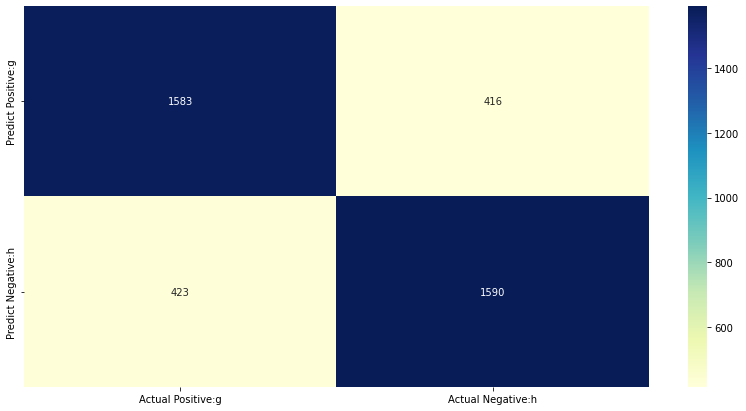

In [ ]:
cm = confusion_matrix(y_pred_tree, y_test)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:g', 'Actual Negative:h'],
                         index=['Predict Positive:g', 'Predict Negative:h'])


plt.figure(figsize = [14, 7])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [ ]:
def metrics(cm_matrix):
  TP = cm_matrix['Actual Positive:g']['Predict Positive:g']
  TN = cm_matrix['Actual Negative:h']['Predict Negative:h']
  FP = cm_matrix['Actual Negative:h']['Predict Positive:g']
  FN = cm_matrix['Actual Positive:g']['Predict Negative:h']

  recall = round(TP / (TP + FN), 4) * 100
  precision = round(TP / (TP + FP), 4) * 100
  accuracy = round((TP + TN) / (FP + FN + TP +TN), 4) * 100
  specificity = round(TN / (TN + FP), 4) * 100
  f1_score = round((2 * recall * precision) / (recall + precision), 2)

  print("Accuracy= {:.2f}".format(accuracy))
  print("Precision= {:.2f}".format(precision))
  print("Recall= {:.2f}".format(recall))
  print("F1 score= {:.2f}".format(f1_score))
  print("specificty= {:.2f}".format(specificity))

In [ ]:
metrics(cm_matrix)

Accuracy= 79.09
Precision= 79.19
Recall= 78.91
F1 score= 79.05
specificty= 79.26


### Naive-Bayes

In [ ]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)

GaussianNB()

In [ ]:
y_pred_naive = naive_bayes.predict(X_test)

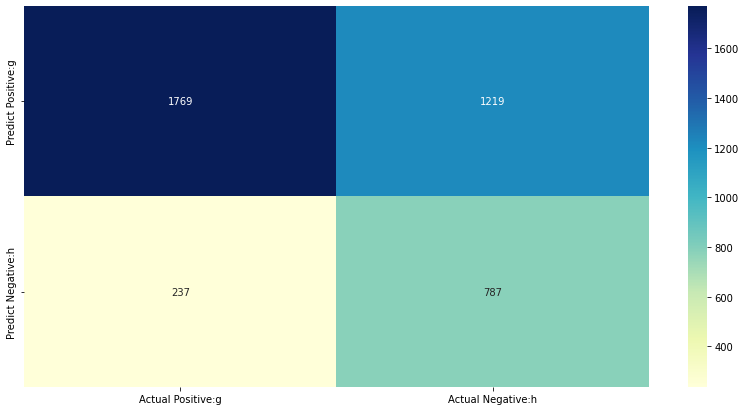

In [ ]:
cm = confusion_matrix(y_pred_naive, y_test)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:g', 'Actual Negative:h'],
                         index=['Predict Positive:g', 'Predict Negative:h'])


plt.figure(figsize = [14, 7])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [ ]:
metrics(cm_matrix)

Accuracy= 63.71
Precision= 59.20
Recall= 88.19
F1 score= 70.84
specificty= 39.23


Here we notice a low accuracy because the features are dependent but **Naive-Bayes** assumes they are independent

### K Nearest Neighbors

#### Step 10

In [ ]:
candidates = range(3, 100, 10)
k = 5

accuracies, best_candidate = cross_validation(k, X_train, y_train, candidates, 'knn')

Accuracy=  79.72251867662754  canditate=  3 

Accuracy=  80.75773745997864  canditate=  13 

Accuracy=  80.60832443970118  canditate=  23 

Accuracy=  80.20277481323373  canditate=  33 

Accuracy=  80.4375667022412  canditate=  43 

Accuracy=  80.16008537886871  canditate=  53 

Accuracy=  80.27748132337248  canditate=  63 

Accuracy=  79.88260405549626  canditate=  73 

Accuracy=  79.70117395944504  canditate=  83 

Accuracy=  79.4983991462113  canditate=  93 



In [ ]:
best_candidate

13

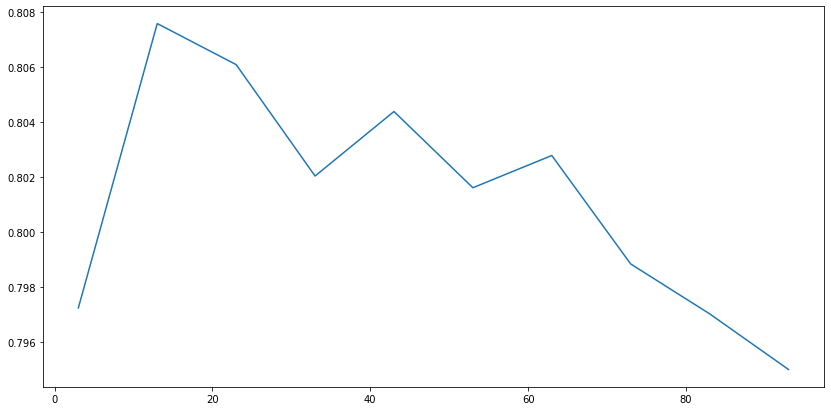

In [ ]:
plt.figure(figsize = [14, 7])

sns.lineplot(x=candidates, y=accuracies)

plt.show()

#### Step 1

In [ ]:
candidates = range(best_candidate - 9, best_candidate + 10)
k = 5

accuracies, best_candidate = cross_validation(k, X_train, y_train, candidates, 'knn')

Accuracy=  78.92209178228387  canditate=  4 

Accuracy=  80.4802561366062  canditate=  5 

Accuracy=  80.08537886872999  canditate=  6 

Accuracy=  80.7043756670224  canditate=  7 

Accuracy=  80.12806830309496  canditate=  8 

Accuracy=  80.97118463180364  canditate=  9 

Accuracy=  80.67235859124867  canditate=  10 

Accuracy=  81.0779082177161  canditate=  11 

Accuracy=  80.52294557097119  canditate=  12 

Accuracy=  80.75773745997864  canditate=  13 

Accuracy=  80.49092849519744  canditate=  14 

Accuracy=  80.7470651013874  canditate=  15 

Accuracy=  80.44823906083245  canditate=  16 

Accuracy=  80.74706510138739  canditate=  17 

Accuracy=  80.29882604055496  canditate=  18 

Accuracy=  80.58697972251866  canditate=  19 

Accuracy=  80.58697972251869  canditate=  20 

Accuracy=  80.71504802561365  canditate=  21 

Accuracy=  80.4162219850587  canditate=  22 



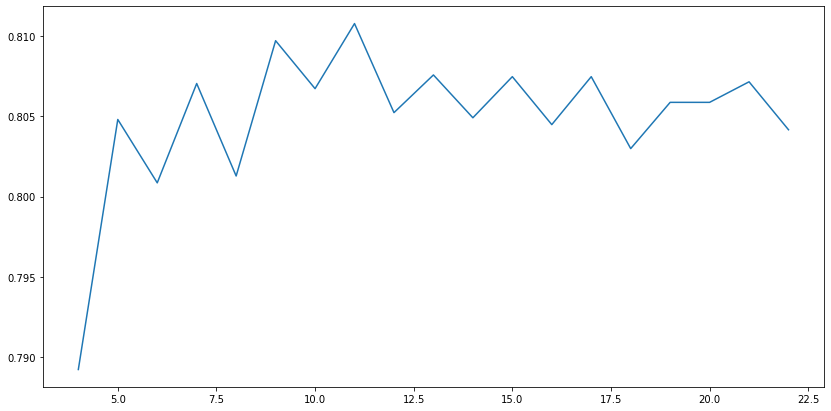

In [ ]:
plt.figure(figsize = [14, 7])
sns.lineplot(x=candidates, y=accuracies)
plt.show()

In [ ]:
best_candidate

11

#### Testing

In [ ]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

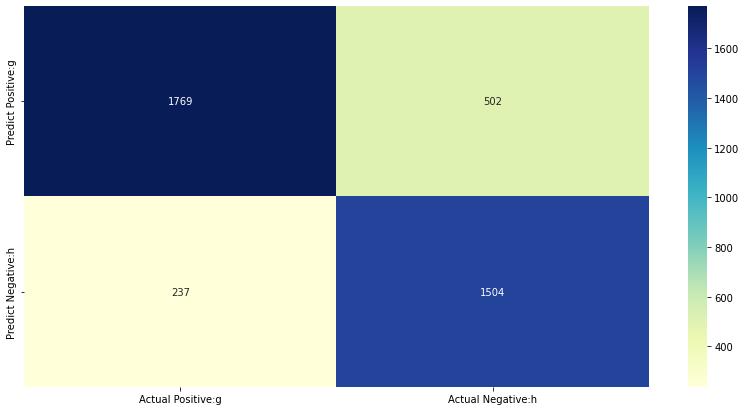

In [ ]:
cm = confusion_matrix(y_pred_knn, y_test)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:g', 'Actual Negative:h'],
                         index=['Predict Positive:g', 'Predict Negative:h'])


plt.figure(figsize = [14, 7])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [ ]:
metrics(cm_matrix)

Accuracy= 81.58
Precision= 77.90
Recall= 88.19
F1 score= 82.73
specificty= 74.98


### Random Forest

#### Step 200

In [ ]:
candidates = range(200, 2001, 200)
k = 5

accuracies, best_candidate = cross_validation(k, X_train, y_train, candidates, 'rf')

Accuracy=  85.85912486659552  canditate=  200 

Accuracy=  85.77374599786553  canditate=  400 

Accuracy=  85.53895410885805  canditate=  600 

Accuracy=  85.70971184631804  canditate=  800 

Accuracy=  85.85912486659552  canditate=  1000 

Accuracy=  85.78441835645678  canditate=  1200 

Accuracy=  85.57097118463179  canditate=  1400 

Accuracy=  85.78441835645677  canditate=  1600 

Accuracy=  85.63500533617929  canditate=  1800 

Accuracy=  85.73105656350053  canditate=  2000 



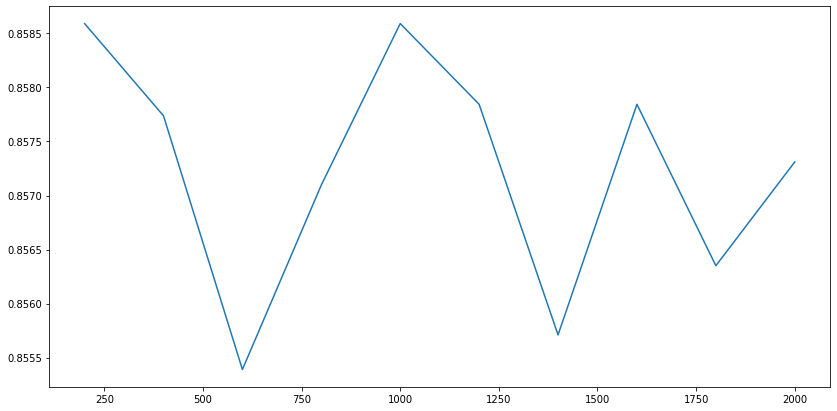

In [ ]:
plt.figure(figsize = [14, 7])

sns.lineplot(x=candidates, y=accuracies)

plt.show()

#### Step 10

In [ ]:
candidates = range(best_candidate - 199, best_candidate + 200, 10)
k = 5

accuracies, best_candidate = cross_validation(k, X_train, y_train, candidates, 'rf')

Accuracy=  76.13660618996799  canditate=  1 

Accuracy=  84.16221985058698  canditate=  11 

Accuracy=  84.82390608324441  canditate=  21 

Accuracy=  84.96264674493062  canditate=  31 

Accuracy=  85.42155816435432  canditate=  41 

Accuracy=  85.46424759871931  canditate=  51 

Accuracy=  85.41088580576307  canditate=  61 

Accuracy=  85.36819637139807  canditate=  71 

Accuracy=  85.47491995731058  canditate=  81 

Accuracy=  85.33617929562433  canditate=  91 

Accuracy=  85.46424759871931  canditate=  101 

Accuracy=  85.66702241195306  canditate=  111 

Accuracy=  85.35752401280683  canditate=  121 

Accuracy=  85.50693703308431  canditate=  131 

Accuracy=  85.64567769477055  canditate=  141 

Accuracy=  85.49626467449306  canditate=  151 

Accuracy=  85.41088580576307  canditate=  161 

Accuracy=  85.75240128068303  canditate=  171 

Accuracy=  85.49626467449306  canditate=  181 

Accuracy=  85.56029882604057  canditate=  191 

Accuracy=  85.56029882604055  canditate=  201 

Acc

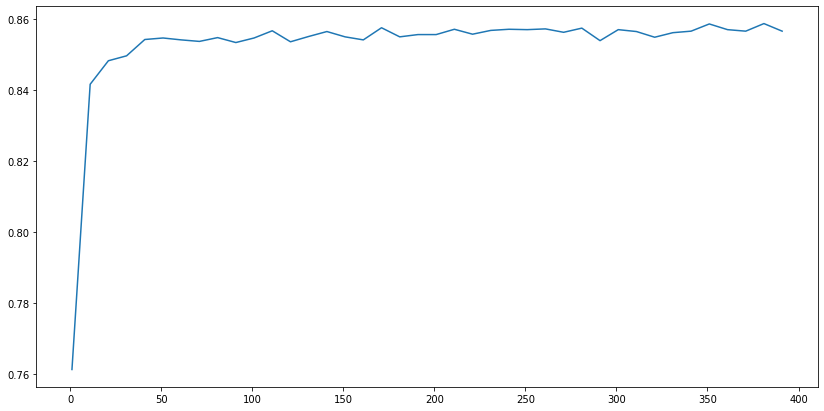

In [ ]:
plt.figure(figsize = [14, 7])

sns.lineplot(x=candidates, y=accuracies)

plt.show()

#### Step 1

In [ ]:
candidates = range(best_candidate - 9, best_candidate + 10)
k = 5

accuracies, best_candidate = cross_validation(k, X_train, y_train, candidates, 'rf')

Accuracy=  85.69903948772681  canditate=  372 

Accuracy=  85.76307363927427  canditate=  373 

Accuracy=  85.64567769477055  canditate=  374 

Accuracy=  85.64567769477055  canditate=  375 

Accuracy=  85.70971184631804  canditate=  376 

Accuracy=  85.60298826040554  canditate=  377 

Accuracy=  85.77374599786553  canditate=  378 

Accuracy=  85.73105656350053  canditate=  379 

Accuracy=  85.52828175026681  canditate=  380 

Accuracy=  85.74172892209178  canditate=  381 

Accuracy=  85.56029882604057  canditate=  382 

Accuracy=  85.69903948772678  canditate=  383 

Accuracy=  85.51760939167556  canditate=  384 

Accuracy=  85.79509071504803  canditate=  385 

Accuracy=  85.53895410885805  canditate=  386 

Accuracy=  85.58164354322304  canditate=  387 

Accuracy=  85.49626467449308  canditate=  388 

Accuracy=  85.58164354322304  canditate=  389 

Accuracy=  85.66702241195303  canditate=  390 



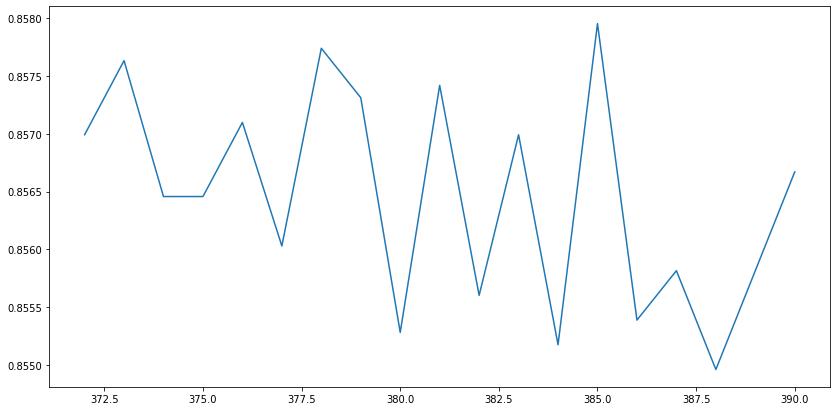

In [ ]:
plt.figure(figsize = [14, 7])

sns.lineplot(x=candidates, y=accuracies)

plt.show()

In [ ]:
best_candidate

385

In [ ]:
rf = RandomForestClassifier(n_estimators=385)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

#### Testing

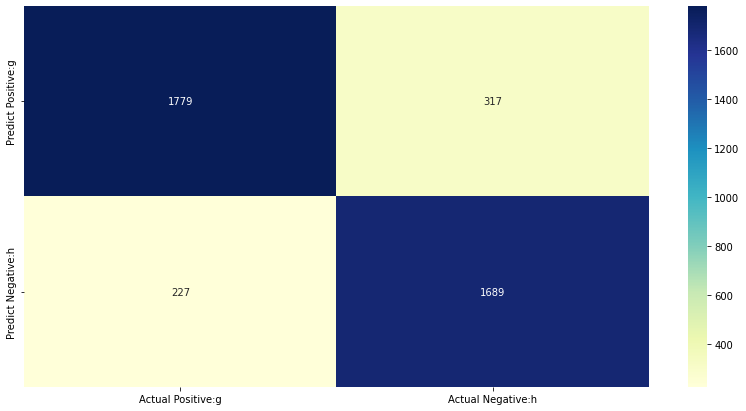

In [ ]:
cm = confusion_matrix(y_pred_rf, y_test)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:g', 'Actual Negative:h'],
                         index=['Predict Positive:g', 'Predict Negative:h'])


plt.figure(figsize = [14, 7])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [ ]:
metrics(cm_matrix)

Accuracy= 86.44
Precision= 84.88
Recall= 88.68
F1 score= 86.74
specificty= 84.20


### Ada Boost

#### Step 200

In [ ]:
candidates = range(1, 2002, 200)
k = 5

accuracies, best_candidate = cross_validation(k, X_train, y_train, candidates, 'ada')

Accuracy=  72.4332977588047  canditate=  1 

Accuracy=  82.62540021344718  canditate=  201 

Accuracy=  82.45464247598719  canditate=  401 

Accuracy=  82.2411953041622  canditate=  601 

Accuracy=  82.24119530416223  canditate=  801 

Accuracy=  82.08110992529349  canditate=  1001 

Accuracy=  82.02774813233724  canditate=  1201 

Accuracy=  82.02774813233725  canditate=  1401 

Accuracy=  81.97438633938103  canditate=  1601 

Accuracy=  81.5795090715048  canditate=  1801 

Accuracy=  81.62219850586979  canditate=  2001 



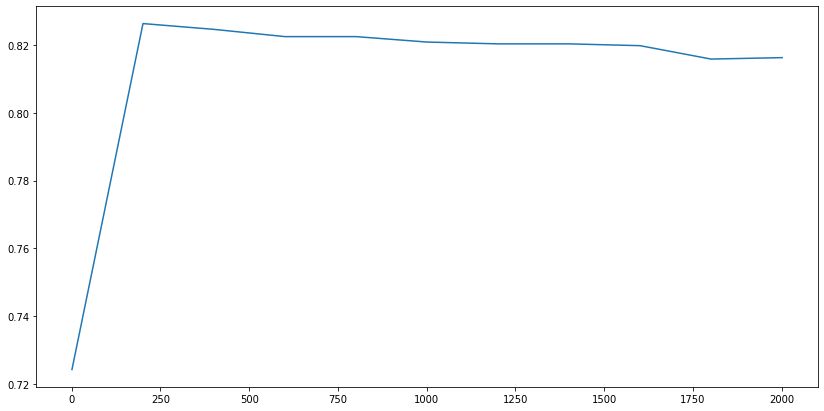

In [ ]:
plt.figure(figsize = [14, 7])

sns.lineplot(x=candidates, y=accuracies)

plt.show()

#### Step 50

In [ ]:
candidates = range(best_candidate - 199, best_candidate + 200, 50)
k = 5

accuracies, best_candidate = cross_validation(k, X_train, y_train, candidates, 'ada')

Accuracy=  73.76734258271078  canditate=  2 

Accuracy=  81.40875133404481  canditate=  52 

Accuracy=  82.14514407684096  canditate=  102 

Accuracy=  82.37993596584845  canditate=  152 

Accuracy=  82.58271077908219  canditate=  202 

Accuracy=  82.52934898612591  canditate=  252 

Accuracy=  82.45464247598719  canditate=  302 

Accuracy=  82.4332977588047  canditate=  352 



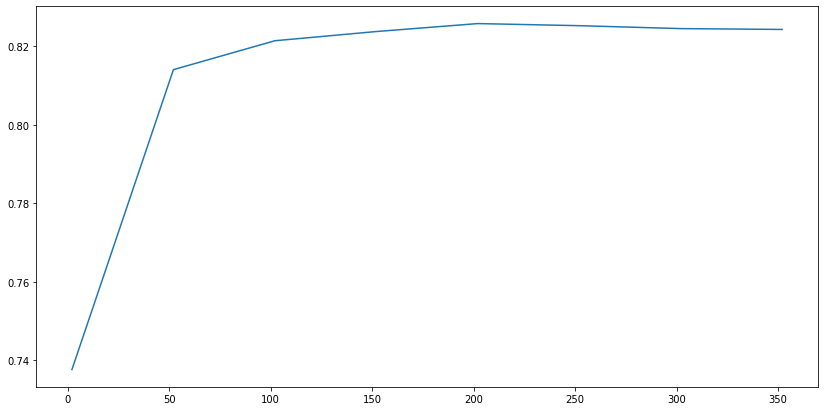

In [ ]:
plt.figure(figsize = [14, 7])

sns.lineplot(x=candidates, y=accuracies)

plt.show()

#### Step 10

In [ ]:
candidates = range(best_candidate - 49, best_candidate + 50, 10)
k = 5

accuracies, best_candidate = cross_validation(k, X_train, y_train, candidates, 'ada')

Accuracy=  82.33724653148346  canditate=  153 

Accuracy=  82.51867662753469  canditate=  163 

Accuracy=  82.52934898612594  canditate=  173 

Accuracy=  82.46531483457844  canditate=  183 

Accuracy=  82.63607257203842  canditate=  193 

Accuracy=  82.55069370330844  canditate=  203 

Accuracy=  82.52934898612594  canditate=  213 

Accuracy=  82.64674493062968  canditate=  223 

Accuracy=  82.61472785485593  canditate=  233 

Accuracy=  82.61472785485593  canditate=  243 



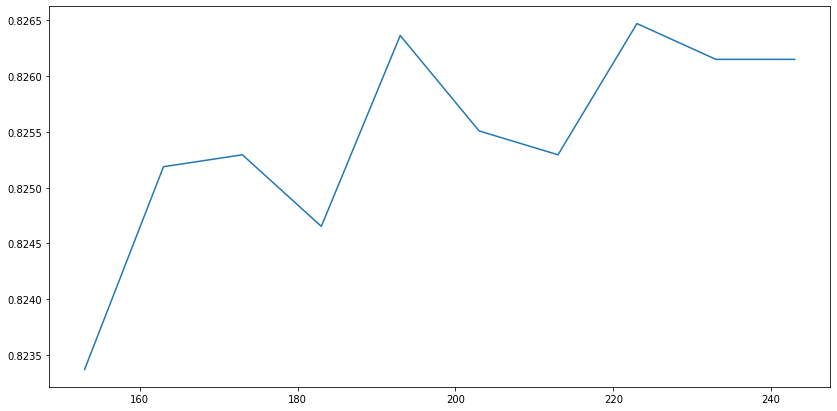

In [ ]:
plt.figure(figsize = [14, 7])

sns.lineplot(x=candidates, y=accuracies)

plt.show()

#### Step 1

In [ ]:
candidates = range(best_candidate - 9, best_candidate + 10)
k = 5

accuracies, best_candidate = cross_validation(k, X_train, y_train, candidates, 'ada')

Accuracy=  82.55069370330844  canditate=  214 

Accuracy=  82.51867662753469  canditate=  215 

Accuracy=  82.58271077908216  canditate=  216 

Accuracy=  82.54002134471719  canditate=  217 

Accuracy=  82.57203842049093  canditate=  218 

Accuracy=  82.54002134471719  canditate=  219 

Accuracy=  82.50800426894344  canditate=  220 

Accuracy=  82.61472785485593  canditate=  221 

Accuracy=  82.58271077908216  canditate=  222 

Accuracy=  82.64674493062968  canditate=  223 

Accuracy=  82.58271077908219  canditate=  224 

Accuracy=  82.62540021344718  canditate=  225 

Accuracy=  82.52934898612594  canditate=  226 

Accuracy=  82.47598719316969  canditate=  227 

Accuracy=  82.55069370330844  canditate=  228 

Accuracy=  82.47598719316969  canditate=  229 

Accuracy=  82.46531483457844  canditate=  230 

Accuracy=  82.46531483457844  canditate=  231 

Accuracy=  82.47598719316969  canditate=  232 



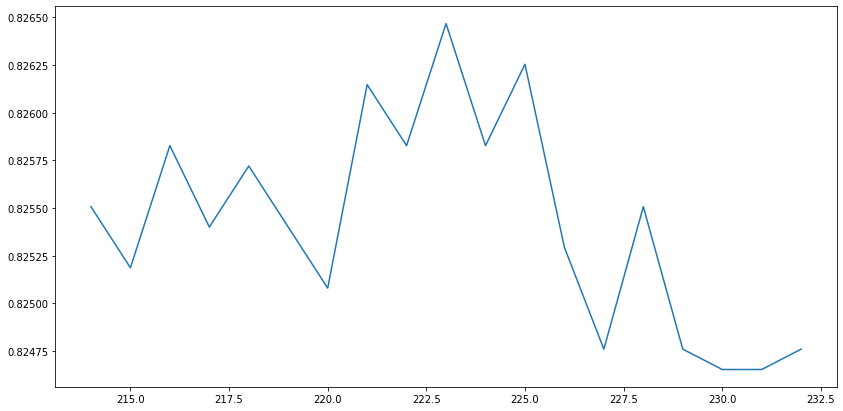

In [ ]:
plt.figure(figsize = [14, 7])

sns.lineplot(x=candidates, y=accuracies)

plt.show()

In [ ]:
best_candidate

223

In [ ]:
ada = AdaBoostClassifier(n_estimators=223)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)

#### Testing

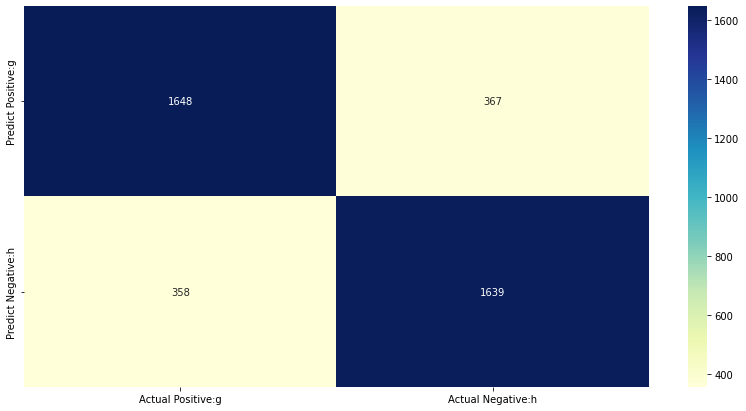

In [ ]:
cm = confusion_matrix(y_pred_ada, y_test)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:g', 'Actual Negative:h'],
                         index=['Predict Positive:g', 'Predict Negative:h'])


plt.figure(figsize = [14, 7])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [ ]:
metrics(cm_matrix)

Accuracy= 81.93
Precision= 81.79
Recall= 82.15
F1 score= 81.97
specificty= 81.70


### Pytorch Neural Network

#### Define Classes and Functions

In [ ]:
y_train.replace({'g':1, 'h':0}, inplace=True)
y_test2 = y_test.replace({'g':1, 'h':0})

In [ ]:
## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
## test or validation data    
class ValData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [ ]:
class BinaryClassification(nn.Module):
    def __init__(self, neurons1, neurons2):
        super(BinaryClassification, self).__init__()
        self.layer_1 = nn.Linear(10, neurons1) 
        self.layer_2 = nn.Linear(neurons1, neurons2)
        self.layer_out = nn.Linear(neurons2, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(neurons1)
        self.batchnorm2 = nn.BatchNorm1d(neurons2)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
cols = X_train.columns
X_train.index = range(len(X_train.index))
y_train.index = range(len(y_train.index))

data2 = pd.concat([X_train, y_train], axis=1)
data_g = data2[data2['class'] == 1]
data_h = data2[data2['class'] == 0]

data_g.index = range(len(data_g.index))
data_h.index = range(len(data_h.index))

rows = data_g.shape[0]

#### Cross Validation

In [ ]:
mean_accs = []
k = 5
for layer1 in range(10, 101, 10):
  for layer2 in range(10, 101, 10):
    accuarcies = []
    offset = 0
    for i in range(k):
      data_val_g = data_g.loc[offset:offset + rows // k]
      data_val_h = data_h.loc[offset:offset + rows // k]
      data_val = pd.concat([data_val_g, data_val_h], axis=0)
      y_val = data_val['class']
      X_val = data_val.drop('class', axis=1)

      data_train_g = data_g.drop(range(offset, offset + rows // k), axis=0)
      data_train_h = data_h.drop(range(offset, offset + rows // k), axis=0)
      data_train = pd.concat([data_train_g, data_train_h], axis=0)
      y_train2 = data_train['class']
      X_train2 = data_train.drop('class', axis=1)

      X_train2 = X_train2.to_numpy()
      X_val = X_val.to_numpy()
      y_train2 = y_train2.to_numpy()
      y_val = y_val.to_numpy()

      train_data = TrainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
      val_data = ValData(torch.FloatTensor(X_val))

      train_loader = DataLoader(dataset=train_data, batch_size=50, shuffle=True)
      val_loader = DataLoader(dataset=val_data, batch_size=1)
      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

      model = BinaryClassification(layer1, layer2)
      model.to(device)
      criterion = nn.BCEWithLogitsLoss()
      optimizer = optim.Adam(model.parameters(), lr=0.001)
      model.train()
      for e in range(1, 51):
          epoch_loss = 0
          epoch_acc = 0
          for X_batch, y_batch in train_loader:
              X_batch, y_batch = X_batch.to(device), y_batch.to(device)
              optimizer.zero_grad()
              
              y_pred = model(X_batch)
              
              loss = criterion(y_pred, y_batch.unsqueeze(1))
              acc = binary_acc(y_pred, y_batch.unsqueeze(1))
              
              loss.backward()
              optimizer.step()
              
              epoch_loss += loss.item()
              epoch_acc += acc.item()
              

          print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
      y_pred_list = []
      model.eval()
      with torch.no_grad():
          for X_batch in val_loader:
              X_batch = X_batch.to(device)
              y_test_pred = model(X_batch)
              y_test_pred = torch.sigmoid(y_test_pred)
              y_pred_tag = torch.round(y_test_pred)
              y_pred_list.append(y_pred_tag.cpu().numpy())

      y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
      accuracy = accuracy_score(y_val, y_pred_list)
      print('\n')
      accuarcies.append(accuracy)
    mean_acc = sum(accuarcies) / len(accuarcies)
    mean_accs.append(mean_acc)
    print('Layer1= ', layer1, 'Layer2=', layer2, 'Accuracy=', mean_acc, '\n')

Streaming output truncated to the last 5000 lines.
Epoch 033: | Loss: 0.34483 | Acc: 84.533
Epoch 034: | Loss: 0.34465 | Acc: 84.613
Epoch 035: | Loss: 0.34493 | Acc: 85.033
Epoch 036: | Loss: 0.35017 | Acc: 83.893
Epoch 037: | Loss: 0.34520 | Acc: 84.787
Epoch 038: | Loss: 0.34360 | Acc: 84.393
Epoch 039: | Loss: 0.35217 | Acc: 84.380
Epoch 040: | Loss: 0.34619 | Acc: 84.233
Epoch 041: | Loss: 0.34309 | Acc: 84.773
Epoch 042: | Loss: 0.34783 | Acc: 84.367
Epoch 043: | Loss: 0.34677 | Acc: 84.160
Epoch 044: | Loss: 0.34194 | Acc: 84.620
Epoch 045: | Loss: 0.34131 | Acc: 84.953
Epoch 046: | Loss: 0.34554 | Acc: 84.493
Epoch 047: | Loss: 0.34915 | Acc: 84.700
Epoch 048: | Loss: 0.34649 | Acc: 84.393
Epoch 049: | Loss: 0.34876 | Acc: 84.380
Epoch 050: | Loss: 0.34002 | Acc: 84.827


Layer1=  90 Layer2= 10 Accuracy= 0.8401280683030949 

Epoch 001: | Loss: 0.46331 | Acc: 78.293
Epoch 002: | Loss: 0.40625 | Acc: 81.587
Epoch 003: | Loss: 0.39154 | Acc: 82.320
Epoch 004: | Loss: 0.38370 | Acc

In [ ]:
print(max(mean_accs))
print(mean_accs.index(max(mean_accs)))

0.8522945570971185
85


In [ ]:
mat= []
for i in range(10):
    row = []
    for j in range(10):
        row.append(mean_accs[i * 10 + j])
    mat.append(row)

In [ ]:
mat = pd.DataFrame(mat, columns=range(10, 101, 10), index=range(10, 101, 10))

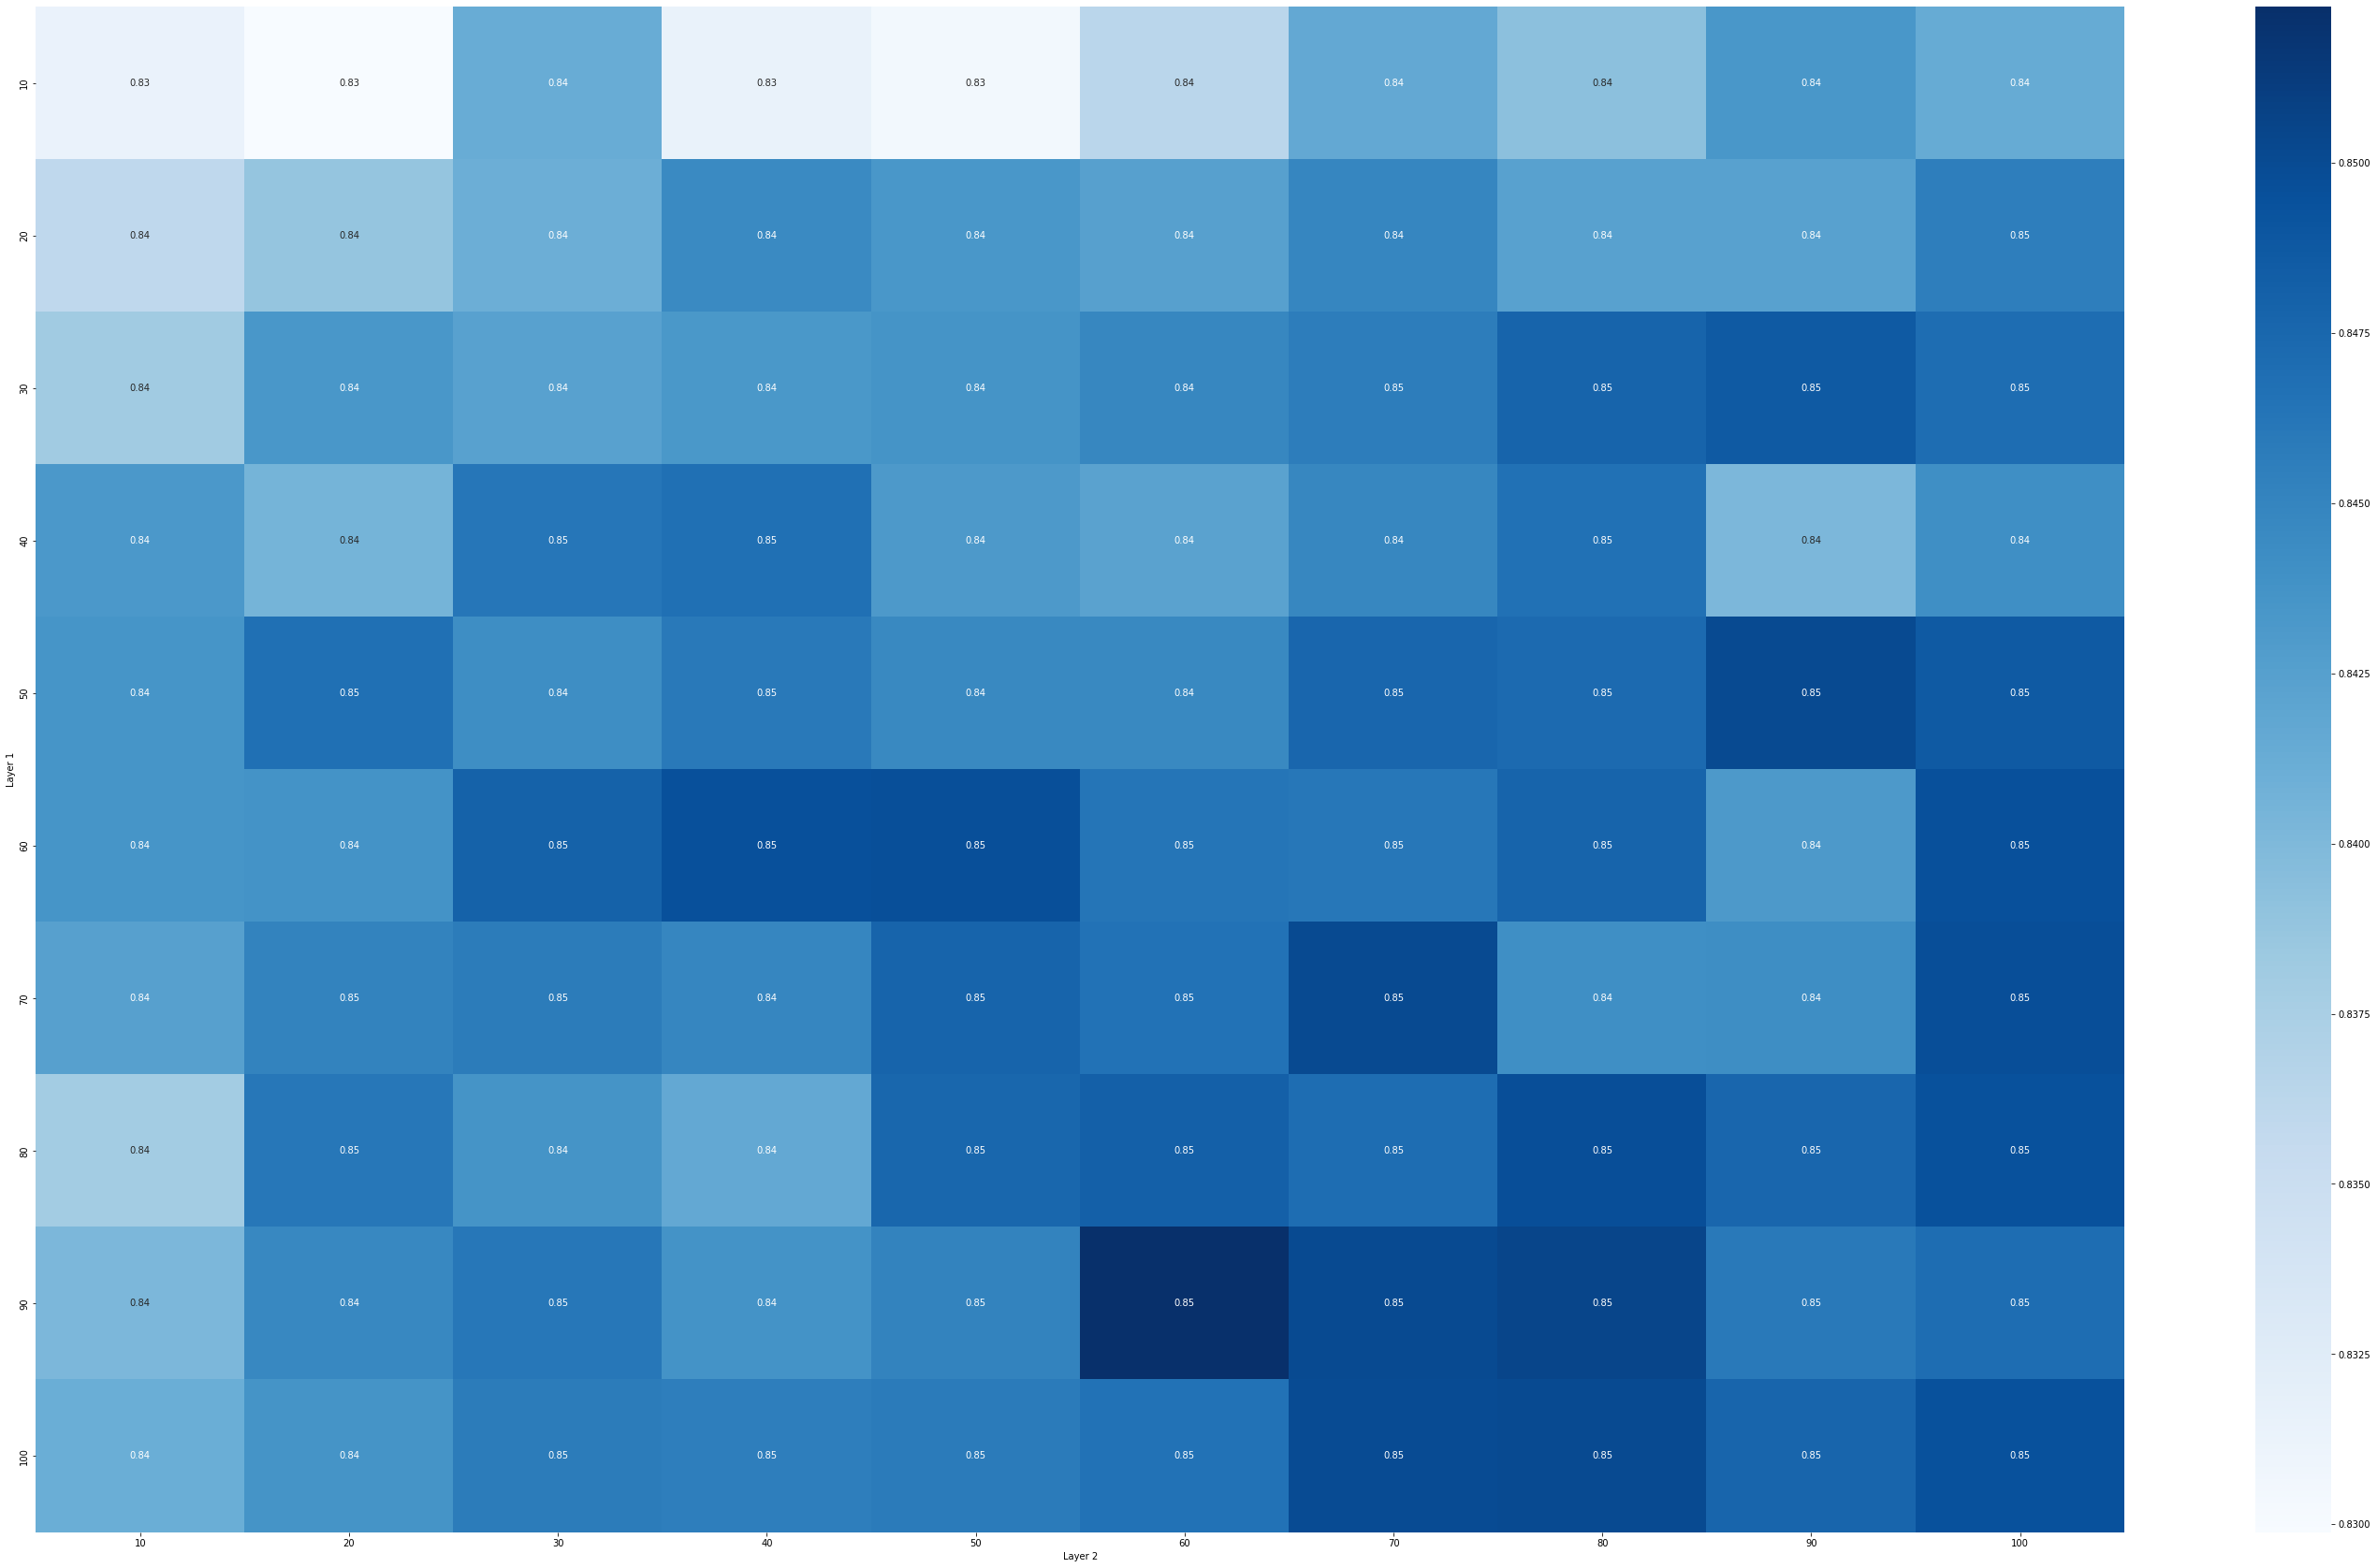

In [ ]:
plt.figure(figsize = [50, 30])

sns.heatmap(mat, annot=True, cmap='Blues')

plt.xlabel("Layer 2")
plt.ylabel("Layer 1")

plt.show()

#### Training

In [ ]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test2 = y_test2.to_numpy()

In [ ]:
train_data = TrainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
test_data = ValData(torch.FloatTensor(X_test))

train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = BinaryClassification(90, 60)
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

for e in range(1, 171):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Train Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.45310 | Train Acc: 78.259
Epoch 002: | Loss: 0.39464 | Train Acc: 82.265
Epoch 003: | Loss: 0.38193 | Train Acc: 83.286
Epoch 004: | Loss: 0.37752 | Train Acc: 83.143
Epoch 005: | Loss: 0.36845 | Train Acc: 83.252
Epoch 006: | Loss: 0.36255 | Train Acc: 83.646
Epoch 007: | Loss: 0.36324 | Train Acc: 84.163
Epoch 008: | Loss: 0.35993 | Train Acc: 83.694
Epoch 009: | Loss: 0.36142 | Train Acc: 83.626
Epoch 010: | Loss: 0.34767 | Train Acc: 84.714
Epoch 011: | Loss: 0.35344 | Train Acc: 84.068
Epoch 012: | Loss: 0.35051 | Train Acc: 84.531
Epoch 013: | Loss: 0.34968 | Train Acc: 84.150
Epoch 014: | Loss: 0.34768 | Train Acc: 84.510
Epoch 015: | Loss: 0.34590 | Train Acc: 84.218
Epoch 016: | Loss: 0.34617 | Train Acc: 84.701
Epoch 017: | Loss: 0.34390 | Train Acc: 84.776
Epoch 018: | Loss: 0.34105 | Train Acc: 84.993
Epoch 019: | Loss: 0.34200 | Train Acc: 84.973
Epoch 020: | Loss: 0.33914 | Train Acc: 84.864
Epoch 021: | Loss: 0.34539 | Train Acc: 84.878
Epoch 022: | 

#### Testing

In [ ]:
y_pred_neural = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_neural.append(y_pred_tag.cpu().numpy())

y_pred_neural = [a.squeeze().tolist() for a in y_pred_neural]

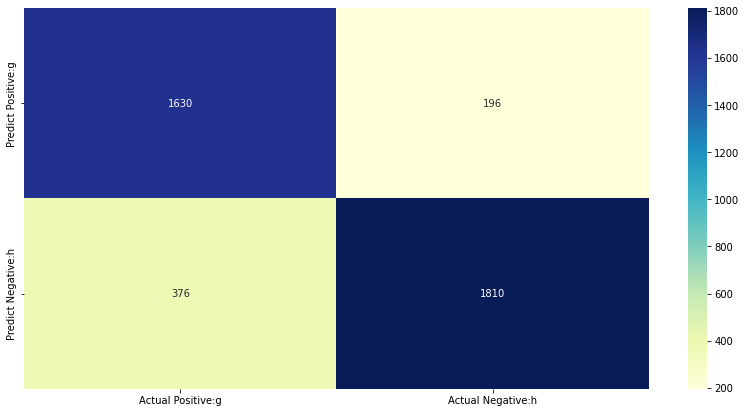

In [ ]:
cm = confusion_matrix(y_pred_neural, y_test2)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:g', 'Actual Negative:h'],
                         index=['Predict Positive:g', 'Predict Negative:h'])


plt.figure(figsize = [14, 7])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [ ]:
metrics(cm_matrix)

Accuracy= 85.74
Precision= 89.27
Recall= 81.26
F1 score= 85.08
specificty= 90.23


## Overall Comparison

In [ ]:
def calc_metrics(cm_matrix):
  TP = cm_matrix['Actual Positive:g']['Predict Positive:g']
  TN = cm_matrix['Actual Negative:h']['Predict Negative:h']
  FP = cm_matrix['Actual Negative:h']['Predict Positive:g']
  FN = cm_matrix['Actual Positive:g']['Predict Negative:h']

  recall = round(TP / (TP + FN), 4) * 100
  precision = round(TP / (TP + FP), 4) * 100
  accuracy = round((TP + TN) / (FP + FN + TP +TN), 4) * 100
  specificity = round(TN / (TN + FP), 4) * 100
  f1_score = round((2 * recall * precision) / (recall + precision), 2)

  return accuracy, precision, recall, specificity, f1_score

In [ ]:
df = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'specificity', 'f1_score'],
                  index=['Decision Tree', 'Naive Bayes', 'KNN', 'Random Forest', 'Ada Boost', 'Neural Network'])

In [ ]:
cm = confusion_matrix(y_pred_tree, y_test)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:g', 'Actual Negative:h'],
                         index=['Predict Positive:g', 'Predict Negative:h'])
df.loc['Decision Tree'] = calc_metrics(cm_matrix)

In [ ]:
cm = confusion_matrix(y_pred_naive, y_test)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:g', 'Actual Negative:h'],
                         index=['Predict Positive:g', 'Predict Negative:h'])
df.loc['Naive Bayes'] = calc_metrics(cm_matrix)

In [ ]:
cm = confusion_matrix(y_pred_knn, y_test)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:g', 'Actual Negative:h'],
                         index=['Predict Positive:g', 'Predict Negative:h'])
df.loc['KNN'] = calc_metrics(cm_matrix)

In [ ]:
cm = confusion_matrix(y_pred_rf, y_test)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:g', 'Actual Negative:h'],
                         index=['Predict Positive:g', 'Predict Negative:h'])
df.loc['Random Forest'] = calc_metrics(cm_matrix)

In [ ]:
cm = confusion_matrix(y_pred_ada, y_test)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:g', 'Actual Negative:h'],
                         index=['Predict Positive:g', 'Predict Negative:h'])
df.loc['Ada Boost'] = calc_metrics(cm_matrix)

In [ ]:
cm = confusion_matrix(y_pred_neural, y_test2)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:g', 'Actual Negative:h'],
                         index=['Predict Positive:g', 'Predict Negative:h'])
df.loc['Neural Network'] = calc_metrics(cm_matrix)

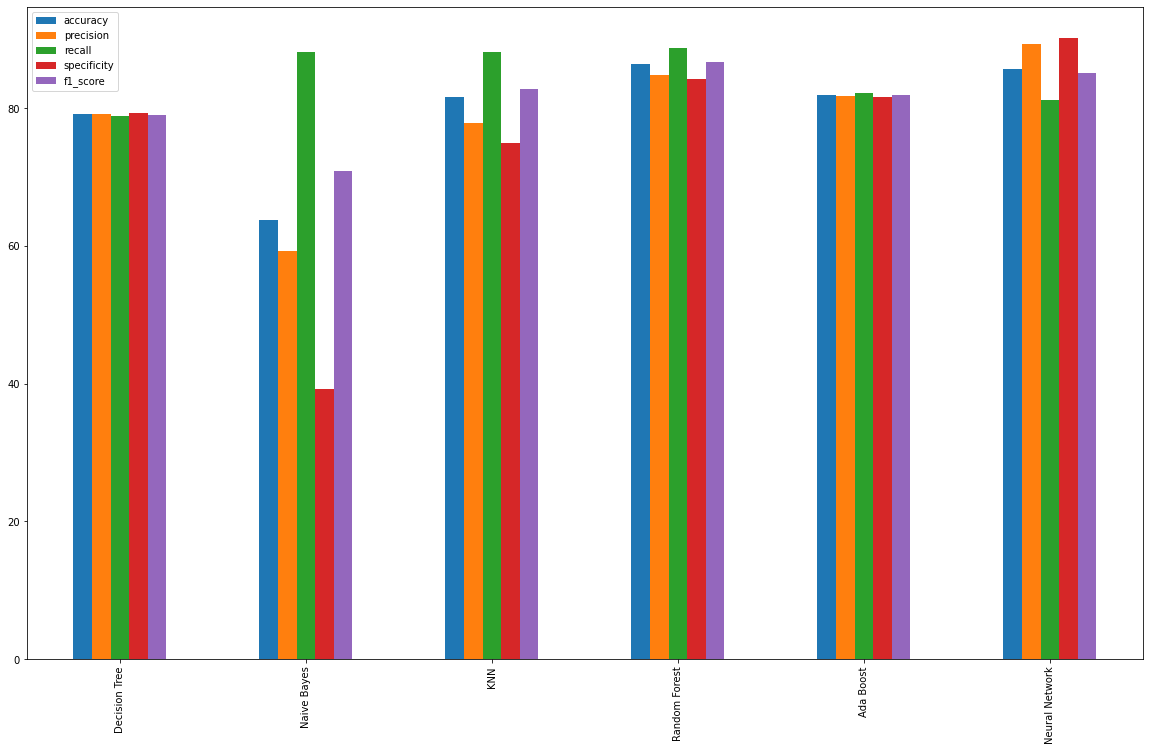

In [ ]:
plt.rcParams["figure.figsize"] = (20,12)
df[['accuracy', 'precision', 'recall', 'specificity', 'f1_score']].plot(kind='bar')

plt.show()